# Diabetes Patient Readmitted Prediction

### Introduction
The goal of this project is to develop a pattern recognition system that operates on a
given real-world dataset. 

### Dataset
Our dataset is: Diabetes 130-US hospitals for years 1999-2008 Data Set.

Source: https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008

The dataset represents 10 years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks. It includes over 50 features representing patient and hospital outcomes. Information was extracted from the database for encounters that satisfied the following criteria.
1. It is an inpatient encounter (a hospital admission).
2. It is a diabetic encounter, that is, one during which any kind of diabetes was entered to the system as a diagnosis.
3. The length of stay was at least 1 day and at most 14 days.
4. Laboratory tests were performed during the encounter.
5. Medications were administered during the encounter.

The data contains such attributes as patient number, race, gender, age, admission type, time in hospital, medical specialty of admitting physician, number of lab test performed, HbA1c test result, diagnosis, number of medication, diabetic medications, number of outpatient, inpatient, and emergency visits in the year before the hospitalization, etc.

The last attribute is our target, indicating the days to inpatient
readmission:
* “<30” if the patient was readmitted in less than 30 days
* “>30” if the patient was readmitted in more than 30 days
* “No” for no record of readmission.

This problem is then a 3-class classification problem.

### Libraries Import

In [234]:
import numpy as np
import pandas as pd 

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

### Data Import

In [143]:
df = pd.read_csv("diabetic_data.csv")

### Data Description

##### Data Header

In [115]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


##### Data Types

In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

* 101766 data points (examples) 
* 50 features, the last one `readmitted` is our target 
* There are some missing data, but `df.info()` does not show them
* The features are either integer ot object (string) type.  

##### Statistical Analysis

In [117]:
df.describe()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.026403e+08,3.869636e+07,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.496119e+07,2.341322e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523890e+08,4.550514e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302709e+08,8.754595e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


##### Missing Data Points

[Text(33.0, 0.5, 'Data Points'),
 Text(0.5, 14.09375, 'Columns'),
 Text(0.5, 1.0, 'Missing Data')]

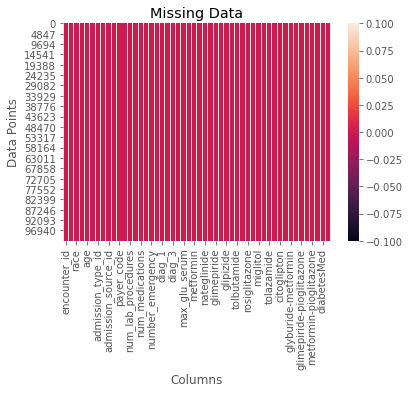

In [118]:
sns.heatmap(df.isnull()).set(title = 'Missing Data', xlabel = 'Columns', ylabel = 'Data Points')

In [119]:
#names of all features
print(list(df))

['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'payer_code', 'medical_specialty', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted']


It looks like our dataset does not store null values as `Nan`, and uses some other characters to refere to different missing values. A full description of each feature in the dataset, and the percentage of missing values can be found on the following links: 
* Features description & missing data percentages: https://www.hindawi.com/journals/bmri/2014/781670/tab1/
* Values of the primary diagnosis: https://www.hindawi.com/journals/bmri/2014/781670/tab2/
* Distribution of variable values: https://www.hindawi.com/journals/bmri/2014/781670/tab3/

Later, we will use `df.feature_name.unique()` & `df.groupby(['feature_name']).count()` to further examine the features which have missing datapoints. 

Notice that in the data secription it is mentioned that there are ~70,000 data points, while there is ~100,000 in our dataset, which means there are some duplicate records that need to be fixed. 

### Data Cleaning

##### Remove Duplicate Data Points

There are 101,766 data points in the dataset, some of them are doublicates. We will use `patient_nbr` column as a reference, since it is a unique number given to each unique patient. 

In [144]:
#df.groupby(['patient_nbr']).count()
df['patient_nbr'].value_counts()

88785891     40
43140906     28
23199021     23
1660293      23
88227540     23
             ..
71081460      1
30060018      1
67443444      1
141344240     1
93251151      1
Name: patient_nbr, Length: 71518, dtype: int64

There is only 71,518 unique patient records out of 101,766 in the dataset. 

In [145]:
df = df.drop_duplicates(subset=['patient_nbr'])

In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71518 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   encounter_id              71518 non-null  int64 
 1   patient_nbr               71518 non-null  int64 
 2   race                      71518 non-null  object
 3   gender                    71518 non-null  object
 4   age                       71518 non-null  object
 5   weight                    71518 non-null  object
 6   admission_type_id         71518 non-null  int64 
 7   discharge_disposition_id  71518 non-null  int64 
 8   admission_source_id       71518 non-null  int64 
 9   time_in_hospital          71518 non-null  int64 
 10  payer_code                71518 non-null  object
 11  medical_specialty         71518 non-null  object
 12  num_lab_procedures        71518 non-null  int64 
 13  num_procedures            71518 non-null  int64 
 14  num_medications      

Now we only have 71518 rows in our dataset.  

##### Remove Uninformative Features

the uninformative features in the dataset (21 in total) were discarded as shown in the table below, due to either, a huge amount of missing sample values (>50%), or due to the fact that somefeatures are not relevant to classify the data towards our target (Like patient ID), or if the feature is compeletly unbalanced (>95% of data points have the same value for the feature).

Feature|Discarding Reasons
---|---
incounter_id|Irrelevant to our target (readmitted)
Patient_nbr|Irrelevant to our target (readmitted)
Weight|97% of samples are missing
Payer_code|Irrelevant to our target (readmitted)
Medical_speciality|53% of samples are missing
Repaglinide|>100K samples not using the drug
Nateglinide|>100K samples not using the drug
Chlorpropamide|>100K samples not using the drug
Acarbose|>100K samples not using the drug
Miglitol|>100K samples not using the drug
Troglitazone|Only 3 patients using the drug
Tolazamide|Only 39 patients using the drug
Examide|All patients not using the drug
Citoglipton|All patients not using the drug
Glyburide_metformin|>100K samples not using the drug
Glipizide_metfotmin|Only 13 patients using the drug
Glimepiride_pioglitazone|Only 1 patient using the drug
Metformin_rosiglitazone|Only 2 patients using the drug
Metformin_pioglitazone|Only 1 patient using the drug
Acetohexamide|Only 1 patient using the drug
tolbutamide|Only 23 patients using the drug

In [146]:
features_drop_list = ['encounter_id', 'patient_nbr', 'weight', 'payer_code', 'medical_specialty', 'repaglinide', 'nateglinide', 'chlorpropamide', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone','metformin-pioglitazone', 'acetohexamide', 'tolbutamide']

In [147]:
df.drop(features_drop_list, axis=1,inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71518 entries, 0 to 101765
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   race                      71518 non-null  object
 1   gender                    71518 non-null  object
 2   age                       71518 non-null  object
 3   admission_type_id         71518 non-null  int64 
 4   discharge_disposition_id  71518 non-null  int64 
 5   admission_source_id       71518 non-null  int64 
 6   time_in_hospital          71518 non-null  int64 
 7   num_lab_procedures        71518 non-null  int64 
 8   num_procedures            71518 non-null  int64 
 9   num_medications           71518 non-null  int64 
 10  number_outpatient         71518 non-null  int64 
 11  number_emergency          71518 non-null  int64 
 12  number_inpatient          71518 non-null  int64 
 13  diag_1                    71518 non-null  object
 14  diag_2               

##### Diag Features Fix

Diag features indicate the diagnoses of the cause of the patien's health problem. 

* diag_1: First diagnose
* diag_2: Second diagnose
* diag_3: Third diagnose

They are coded in ICD-9 code (https://en.wikipedia.org/wiki/List_of_ICD-9_codes), resulting in hundreds of distinct categories. One way to simplify this, is by grouping every ICD-9 code value into one of 18 generic health problems, depending on the first 3 digits as following:   

   * List of ICD-9 codes 001–139: infectious and parasitic diseases
   * List of ICD-9 codes 140–239: neoplasms
   * List of ICD-9 codes 240–279: endocrine, nutritional and metabolic diseases, and immunity disorders
   * List of ICD-9 codes 280–289: diseases of the blood and blood-forming organs
   * List of ICD-9 codes 290–319: mental disorders
   * List of ICD-9 codes 320–389: diseases of the nervous system and sense organs
   * List of ICD-9 codes 390–459: diseases of the circulatory system
   * List of ICD-9 codes 460–519: diseases of the respiratory system
   * List of ICD-9 codes 520–579: diseases of the digestive system
   * List of ICD-9 codes 580–629: diseases of the genitourinary system
   * List of ICD-9 codes 630–679: complications of pregnancy, childbirth, and the puerperium
   * List of ICD-9 codes 680–709: diseases of the skin and subcutaneous tissue
   * List of ICD-9 codes 710–739: diseases of the musculoskeletal system and connective tissue
   * List of ICD-9 codes 740–759: congenital anomalies
   * List of ICD-9 codes 760–779: certain conditions originating in the perinatal period
   * List of ICD-9 codes 780–799: symptoms, signs, and ill-defined conditions
   * List of ICD-9 codes 800–999: injury and poisoning
   * List of ICD-9 codes E and V codes: external causes of injury and supplemental classification
   
   After that we will fill the missing values with E and V codes

In [148]:
#start by setting all values containing E or V into 0 (as one category)
df.loc[df['diag_1'].str.contains('V',na=False,case=False), 'diag_1'] = 0
df.loc[df['diag_1'].str.contains('E',na=False,case=False), 'diag_1'] = 0
df.loc[df['diag_2'].str.contains('V',na=False,case=False), 'diag_2'] = 0
df.loc[df['diag_2'].str.contains('E',na=False,case=False), 'diag_2'] = 0
df.loc[df['diag_3'].str.contains('V',na=False,case=False), 'diag_3'] = 0
df.loc[df['diag_3'].str.contains('E',na=False,case=False), 'diag_3'] = 0

#setting all missing values into -1
df['diag_1'] = df['diag_1'].replace('?', -1)
df['diag_2'] = df['diag_2'].replace('?', -1)
df['diag_3'] = df['diag_3'].replace('?', -1)

#No all diag values can be converted into numeric values
df['diag_1'] = df['diag_1'].astype(float)
df['diag_2'] = df['diag_2'].astype(float)
df['diag_3'] = df['diag_3'].astype(float)


In [154]:
#Now we will reduce the number of categories in diag features according to ICD-9 code
#(Missing values will be grouped as E & V values)
df['diag_1'].loc[(df['diag_1']>=1) & (df['diag_1']< 140)] = 1
df['diag_1'].loc[(df['diag_1']>=140) & (df['diag_1']< 240)] = 2
df['diag_1'].loc[(df['diag_1']>=240) & (df['diag_1']< 280)] = 3
df['diag_1'].loc[(df['diag_1']>=280) & (df['diag_1']< 290)] = 4
df['diag_1'].loc[(df['diag_1']>=290) & (df['diag_1']< 320)] = 5
df['diag_1'].loc[(df['diag_1']>=320) & (df['diag_1']< 390)] = 6
df['diag_1'].loc[(df['diag_1']>=390) & (df['diag_1']< 460)] = 7
df['diag_1'].loc[(df['diag_1']>=460) & (df['diag_1']< 520)] = 8
df['diag_1'].loc[(df['diag_1']>=520) & (df['diag_1']< 580)] = 9
df['diag_1'].loc[(df['diag_1']>=580) & (df['diag_1']< 630)] = 10
df['diag_1'].loc[(df['diag_1']>=630) & (df['diag_1']< 680)] = 11
df['diag_1'].loc[(df['diag_1']>=680) & (df['diag_1']< 710)] = 12
df['diag_1'].loc[(df['diag_1']>=710) & (df['diag_1']< 740)] = 13
df['diag_1'].loc[(df['diag_1']>=740) & (df['diag_1']< 760)] = 14
df['diag_1'].loc[(df['diag_1']>=760) & (df['diag_1']< 780)] = 15
df['diag_1'].loc[(df['diag_1']>=780) & (df['diag_1']< 800)] = 16
df['diag_1'].loc[(df['diag_1']>=800) & (df['diag_1']< 1000)] = 17
df['diag_1'].loc[(df['diag_1']==-1)] = 0

df['diag_2'].loc[(df['diag_2']>=1) & (df['diag_2']< 140)] = 1
df['diag_2'].loc[(df['diag_2']>=140) & (df['diag_2']< 240)] = 2
df['diag_2'].loc[(df['diag_2']>=240) & (df['diag_2']< 280)] = 3
df['diag_2'].loc[(df['diag_2']>=280) & (df['diag_2']< 290)] = 4
df['diag_2'].loc[(df['diag_2']>=290) & (df['diag_2']< 320)] = 5
df['diag_2'].loc[(df['diag_2']>=320) & (df['diag_2']< 390)] = 6
df['diag_2'].loc[(df['diag_2']>=390) & (df['diag_2']< 460)] = 7
df['diag_2'].loc[(df['diag_2']>=460) & (df['diag_2']< 520)] = 8
df['diag_2'].loc[(df['diag_2']>=520) & (df['diag_2']< 580)] = 9
df['diag_2'].loc[(df['diag_2']>=580) & (df['diag_2']< 630)] = 10
df['diag_2'].loc[(df['diag_2']>=630) & (df['diag_2']< 680)] = 11
df['diag_2'].loc[(df['diag_2']>=680) & (df['diag_2']< 710)] = 12
df['diag_2'].loc[(df['diag_2']>=710) & (df['diag_2']< 740)] = 13
df['diag_2'].loc[(df['diag_2']>=740) & (df['diag_2']< 760)] = 14
df['diag_2'].loc[(df['diag_2']>=760) & (df['diag_2']< 780)] = 15
df['diag_2'].loc[(df['diag_2']>=780) & (df['diag_2']< 800)] = 16
df['diag_2'].loc[(df['diag_2']>=800) & (df['diag_2']< 1000)] = 17
df['diag_2'].loc[(df['diag_2']==-1)] = 0

df['diag_3'].loc[(df['diag_3']>=1) & (df['diag_3']< 140)] = 1
df['diag_3'].loc[(df['diag_3']>=140) & (df['diag_3']< 240)] = 2
df['diag_3'].loc[(df['diag_3']>=240) & (df['diag_3']< 280)] = 3
df['diag_3'].loc[(df['diag_3']>=280) & (df['diag_3']< 290)] = 4
df['diag_3'].loc[(df['diag_3']>=290) & (df['diag_3']< 320)] = 5
df['diag_3'].loc[(df['diag_3']>=320) & (df['diag_3']< 390)] = 6
df['diag_3'].loc[(df['diag_3']>=390) & (df['diag_3']< 460)] = 7
df['diag_3'].loc[(df['diag_3']>=460) & (df['diag_3']< 520)] = 8
df['diag_3'].loc[(df['diag_3']>=520) & (df['diag_3']< 580)] = 9
df['diag_3'].loc[(df['diag_3']>=580) & (df['diag_3']< 630)] = 10
df['diag_3'].loc[(df['diag_3']>=630) & (df['diag_3']< 680)] = 11
df['diag_3'].loc[(df['diag_3']>=680) & (df['diag_3']< 710)] = 12
df['diag_3'].loc[(df['diag_3']>=710) & (df['diag_3']< 740)] = 13
df['diag_3'].loc[(df['diag_3']>=740) & (df['diag_3']< 760)] = 14
df['diag_3'].loc[(df['diag_3']>=760) & (df['diag_3']< 780)] = 15
df['diag_3'].loc[(df['diag_3']>=780) & (df['diag_3']< 800)] = 16
df['diag_3'].loc[(df['diag_3']>=800) & (df['diag_3']< 1000)] = 17
df['diag_3'].loc[(df['diag_3']==-1)] = 0

/home/trojan/miniconda3/envs/ds/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [161]:
#check the results
df.diag_1.unique()

array([ 3., 11.,  1.,  2.,  7.,  8., 17., 12., 13.,  9.,  0., 16., 10.,
        5.,  6.,  4., 14.])

##### Race Feature Fix

Here we will replace the missing data points values with 'Other' category, as most likely people who skip filling their race have done that because they couldn't find their race listed within the options. 

In [163]:
df['race'] = df['race'].replace('?', 'Other')

In [164]:
df.race.value_counts()

Caucasian          53491
AfricanAmerican    12887
Other               3126
Hispanic            1517
Asian                497
Name: race, dtype: int64

##### Gender Feature Fix

In [166]:
df.gender.value_counts()

Female             38025
Male               33490
Unknown/Invalid        3
Name: gender, dtype: int64

Here we have just 3 values that are Invalid, as a result we will change them into `Female`, which is the mod for this feature. 

In [167]:
df['gender'] = df['gender'].replace('Unknown/Invalid', 'Female')
df.gender.value_counts()

Female    38028
Male      33490
Name: gender, dtype: int64

Now we can easliy change Male/Female into 1/0

In [170]:
df['gender'] = df['gender'].replace('Male', 1)
df['gender'] = df['gender'].replace('Female', 0)
df.gender.value_counts()

0    38028
1    33490
Name: gender, dtype: int64

##### Age Feature Fix

For age, we have 10 categories, each represents 10 years range from [0-10] to [90-100]. We will replace those with the middle age for each age range: 
for example (0,10] will be repleased with 5; (60, 70] will be replaces by 65; and so on. 

In [168]:
df.age.value_counts()

[70-80)     18210
[60-70)     15960
[50-60)     12466
[80-90)     11589
[40-50)      6878
[30-40)      2699
[90-100)     1900
[20-30)      1127
[10-20)       535
[0-10)        154
Name: age, dtype: int64

In [169]:
for i in range(0,10):
    df['age'] = df['age'].replace('['+str(10*i)+'-'+str(10*(i+1))+')', i*10+5)
df['age'].value_counts()

75    18210
65    15960
55    12466
85    11589
45     6878
35     2699
95     1900
25     1127
15      535
5       154
Name: age, dtype: int64

##### max_glue_serum Feature Fix

We want to make the following changes: 

|Raw Values|New Values|
|---|---|
|non|0
|norm|1
|>200|2
|>300|3

In [171]:
df.max_glu_serum.value_counts()

None    68062
Norm     1731
>200      969
>300      756
Name: max_glu_serum, dtype: int64

In [172]:
df['max_glu_serum']=df['max_glu_serum'].replace("None", 0)
df['max_glu_serum']=df['max_glu_serum'].replace("Norm", 1)
df['max_glu_serum']=df['max_glu_serum'].replace(">200", 2)
df['max_glu_serum']=df['max_glu_serum'].replace(">300", 3)
df.max_glu_serum.value_counts()

0    68062
1     1731
2      969
3      756
Name: max_glu_serum, dtype: int64

##### A1Cresult Feature Fix

We want to make the following changes: 

|Raw Values|New Values|
|---|---|
|None|0
|Norm|1
|>7|2
|>8|3

In [173]:
df.A1Cresult.value_counts()

None    58532
>8       6304
Norm     3791
>7       2891
Name: A1Cresult, dtype: int64

In [174]:
df['A1Cresult']=df['A1Cresult'].replace("None", 0)
df['A1Cresult']=df['A1Cresult'].replace("Norm", 1)
df['A1Cresult']=df['A1Cresult'].replace(">7", 2)
df['A1Cresult']=df['A1Cresult'].replace(">8", 3)

0    68062
1     1731
2      969
3      756
Name: max_glu_serum, dtype: int64

In [175]:
df.A1Cresult.value_counts()

0    58532
3     6304
1     3791
2     2891
Name: A1Cresult, dtype: int64

##### Drugs Features Fix

We still have 7 features, each one represents the change in the patient's dusage of a specific drug, during hospital encounter. Those 7 drugs are the following: 
* metformin                 
*  glimepiride              
*  glipizide              
*  glyburide                
*  pioglitazone             
*  rosiglitazone          
*  insulin     

For all those drugs, we want to apply the following changes, since the values are ordinal categories: 

|Raw Values|New Values|
|---|---|
|No|0|
|Down|1|
|Steady|2|
|Up|3|

In [176]:
#df.metformin.value_counts()
#df.glimepiride.value_counts()
#df.glipizide.value_counts()
#df.glyburide.value_counts()
#df.pioglitazone.value_counts()
#df.rosiglitazone.value_counts()
df.insulin.value_counts()

No        34921
Steady    22129
Down       7505
Up         6963
Name: insulin, dtype: int64

In [177]:
drug_list = ['metformin', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'insulin']
for i in drug_list:
    df[i] = df[i].replace('No', 0)
    df[i] = df[i].replace('Steady', 2)
    df[i] = df[i].replace('Down', 1)
    df[i] = df[i].replace('Up', 3)

In [178]:
#df.metformin.value_counts()
#df.glimepiride.value_counts()
#df.glipizide.value_counts()
#df.glyburide.value_counts()
#df.pioglitazone.value_counts()
#df.rosiglitazone.value_counts()
df.insulin.value_counts()

0    34921
2    22129
1     7505
3     6963
Name: insulin, dtype: int64

##### Change Feature Fix

We want to change the values of the feature `change` from string into binary numeric. 

In [179]:
df.change.value_counts()

No    39494
Ch    32024
Name: change, dtype: int64

In [180]:
df['change']=df['change'].replace('No', 0)
df['change']=df['change'].replace('Ch', 1)
df.change.value_counts()

0    39494
1    32024
Name: change, dtype: int64

##### DiabetesMed Feature Fix

We want to change the values of the feature `diabetesMed` from string into binary numeric. 

In [181]:
df.diabetesMed.value_counts()

Yes    54319
No     17199
Name: diabetesMed, dtype: int64

In [182]:
df['diabetesMed']=df['diabetesMed'].replace('Yes', 1)
df['diabetesMed']=df['diabetesMed'].replace('No', 0)
df.diabetesMed.value_counts()

1    54319
0    17199
Name: diabetesMed, dtype: int64

##### Target Feature Fix

The outcome we are looking at in the labels is whether the patient gets readmitted to the hospital within 30 days, after 30 days, or not readmitted again. The variable actually has <30, >30 and No Readmission categories.

In [183]:
df.readmitted.value_counts()

NO     42985
>30    22240
<30     6293
Name: readmitted, dtype: int64

Here we will use a simple encoding as following: 

In [185]:
df['readmitted']=df['readmitted'].replace('NO', 0)
df['readmitted']=df['readmitted'].replace('>30', 1)
df['readmitted']=df['readmitted'].replace('<30', 2)
df.readmitted.value_counts()

0    42985
1    22240
2     6293
Name: readmitted, dtype: int64

### EDA

In [186]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71518 entries, 0 to 101765
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   race                      71518 non-null  object 
 1   gender                    71518 non-null  int64  
 2   age                       71518 non-null  int64  
 3   admission_type_id         71518 non-null  int64  
 4   discharge_disposition_id  71518 non-null  int64  
 5   admission_source_id       71518 non-null  int64  
 6   time_in_hospital          71518 non-null  int64  
 7   num_lab_procedures        71518 non-null  int64  
 8   num_procedures            71518 non-null  int64  
 9   num_medications           71518 non-null  int64  
 10  number_outpatient         71518 non-null  int64  
 11  number_emergency          71518 non-null  int64  
 12  number_inpatient          71518 non-null  int64  
 13  diag_1                    71518 non-null  float64
 14  diag_

##### Correlation Analysis

Let's first check how correlated are our predectors

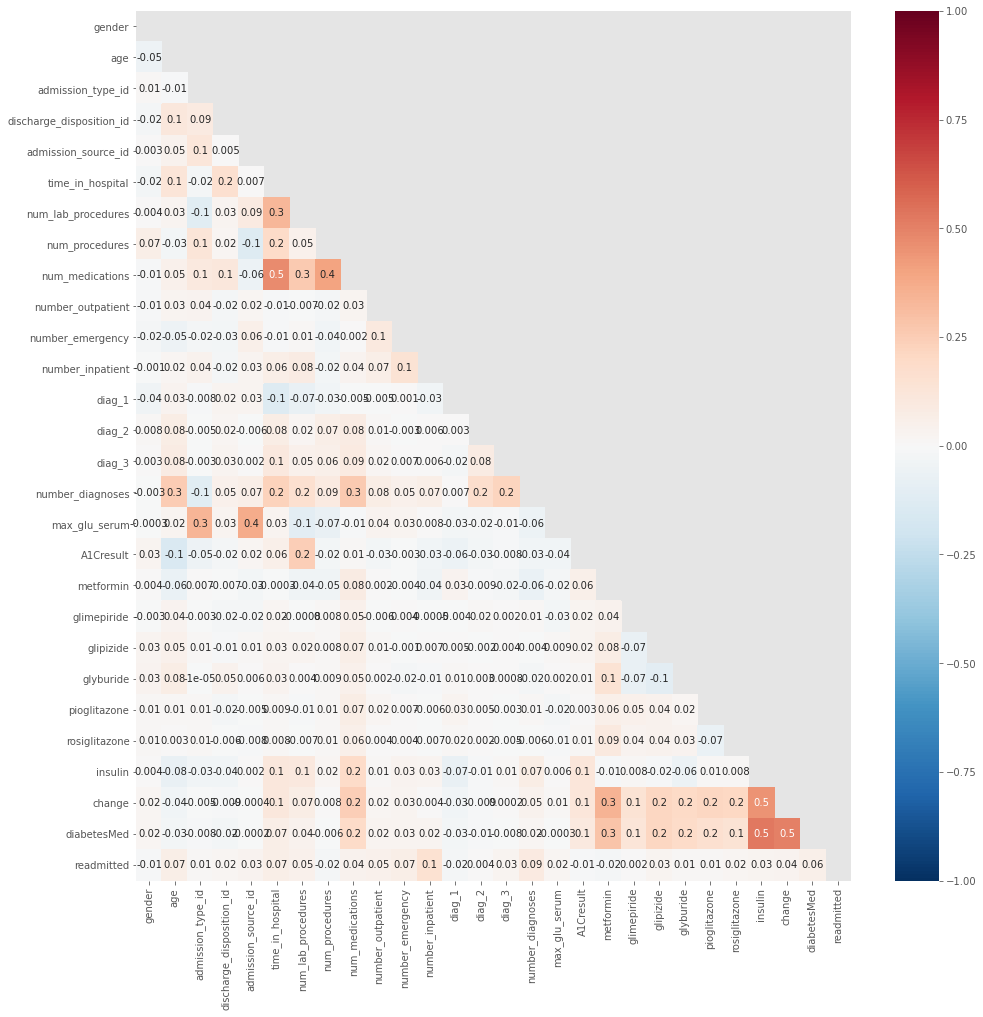

In [188]:
matrix = np.triu(df.corr())
fig, ax = plt.subplots(figsize=(16,16))
sns.heatmap(df.corr(), annot=True, ax=ax, fmt='.1g', vmin=-1, vmax=1, center= 0, mask=matrix, cmap='RdBu_r')
plt.show()

* The strongest correlations among the predectors are: 
    * num_medications & time_in_hospital (corr = 0.5)
    * change & insulin (corr = 0.5)
    * change & diabetesMed (corr = 0.5)
    * diabetesMed & insulin (corr = 0.5)
* Also, our labels `readmitted` has in general week correlation with all predictors. 

##### Patient Analysis

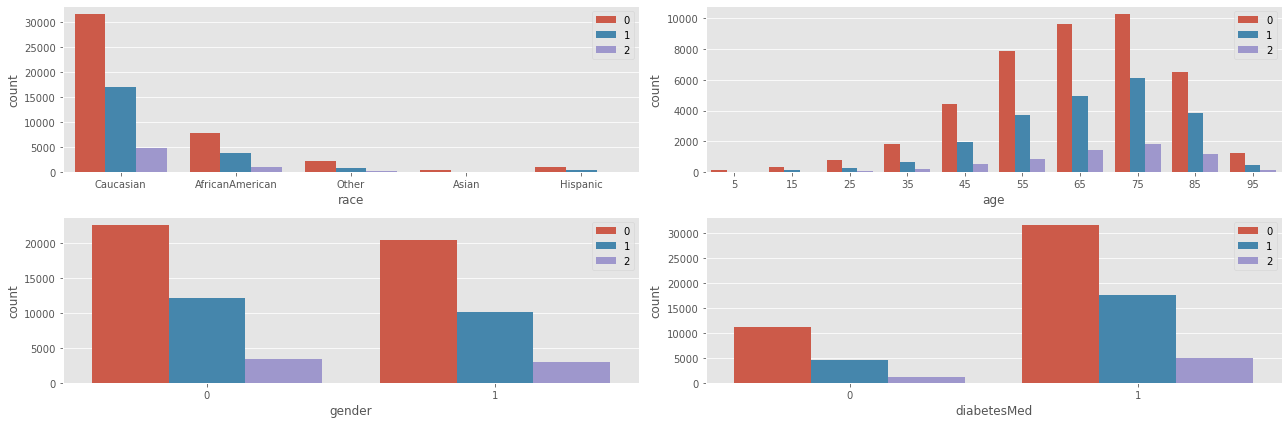

In [189]:
fig = plt.figure(figsize=(18, 6))

ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)

sns.countplot(data=df, x='race', hue='readmitted', ax=ax1)
sns.countplot(data=df, x='age', hue='readmitted', ax=ax2)
sns.countplot(data=df, x='gender', hue='readmitted', ax=ax3)
sns.countplot(data=df, x='diabetesMed', hue='readmitted', ax=ax4)

ax1.legend(loc='upper right')
ax2.legend(loc='upper right')
ax3.legend(loc='upper right')
ax4.legend(loc='upper right')
plt.tight_layout()
plt.show()
# readmitted: 0 = No, 1 = >30, 2 = <30

* readmittion has simmilar distripution across different races. 
* Very few cases of readmition for youbnger patients (< 40). 
* Females have slightly higher rate of no readmittion than males. 
* readmittion has simmilar distripution for patients with and without prescribed diabetes medications prior to hospital encounter. 

##### Drugs Analysis

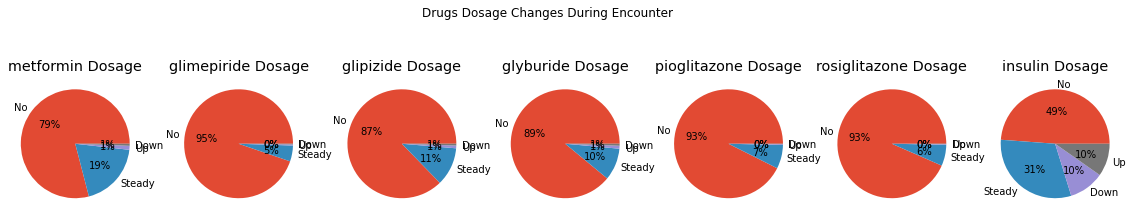

In [208]:
fig, ax = plt.subplots(1, 7,figsize=(20, 4), subplot_kw=dict(aspect="equal"))
ax[0].pie(df['metformin'].value_counts(), autopct='%1.0f%%', labels=['No', 'Steady', 'Up', 'Down'])
ax[0].set_title('metformin Dosage')
ax[1].pie(df['glimepiride'].value_counts(), autopct='%1.0f%%', labels=['No', 'Steady', 'Up', 'Down'])
ax[1].set_title('glimepiride Dosage')
ax[2].pie(df['glipizide'].value_counts(), autopct='%1.0f%%', labels=['No', 'Steady', 'Up', 'Down'])
ax[2].set_title('glipizide Dosage')
ax[3].pie(df['glyburide'].value_counts(), autopct='%1.0f%%', labels=['No', 'Steady', 'Up', 'Down'])
ax[3].set_title('glyburide Dosage')
ax[4].pie(df['pioglitazone'].value_counts(), autopct='%1.0f%%', labels=['No', 'Steady', 'Up', 'Down'])
ax[4].set_title('pioglitazone Dosage')
ax[5].pie(df['rosiglitazone'].value_counts(), autopct='%1.0f%%', labels=['No', 'Steady', 'Up', 'Down'])
ax[5].set_title('rosiglitazone Dosage')
ax[6].pie(df['insulin'].value_counts(), autopct='%1.0f%%', labels=['No', 'Steady', 'Down', 'Up'])
ax[6].set_title('insulin Dosage')

fig.suptitle('Drugs Dosage Changes During Encounter')
plt.show()

Except of insulin, the other drugs have very similar distripution. 

##### Time in Hospital and Readmission

Text(0.5, 1.0, 'Time in Hospital VS. Readmission')

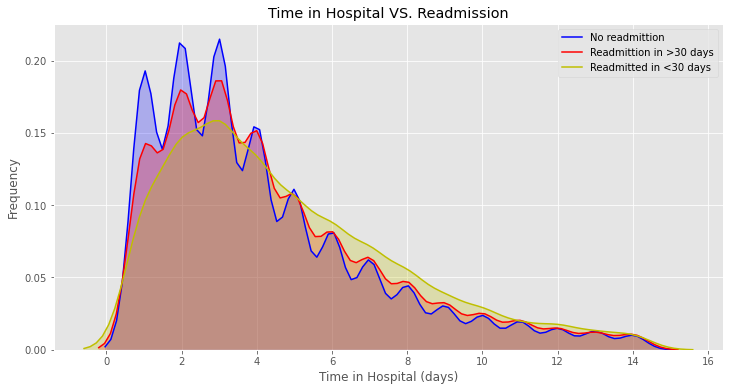

In [212]:
fig = plt.figure(figsize=(12,6))
ax=sns.kdeplot(df.loc[(df['readmitted'] == 0),'time_in_hospital'] , color='b',shade=True,label='No readmittion')
ax=sns.kdeplot(df.loc[(df['readmitted'] == 1),'time_in_hospital'] , color='r',shade=True, label='Readmittion in >30 days')
ax=sns.kdeplot(df.loc[(df['readmitted'] == 2),'time_in_hospital'] , color='y',shade=True, label='Readmitted in <30 days')
ax.set(xlabel='Time in Hospital (days)', ylabel='Frequency')
plt.title('Time in Hospital VS. Readmission')

The very similar distripution of time_in_hospital over the 3 classes reflects the very weak correlation between our targets (readmitted) and time_in_hospital predictor. 

### Data Pre-processing

##### Race Feature Encoding

Race feature has catagorical values stored as strings ('Asian', ... etc). Dummy coding scheme is used to encode the race feature. This categorical data encoding method transforms the categorical variable into an N-1 set of binary variables (also known as dummy variables). 

In [214]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71518 entries, 0 to 101765
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   race                      71518 non-null  object 
 1   gender                    71518 non-null  int64  
 2   age                       71518 non-null  int64  
 3   admission_type_id         71518 non-null  int64  
 4   discharge_disposition_id  71518 non-null  int64  
 5   admission_source_id       71518 non-null  int64  
 6   time_in_hospital          71518 non-null  int64  
 7   num_lab_procedures        71518 non-null  int64  
 8   num_procedures            71518 non-null  int64  
 9   num_medications           71518 non-null  int64  
 10  number_outpatient         71518 non-null  int64  
 11  number_emergency          71518 non-null  int64  
 12  number_inpatient          71518 non-null  int64  
 13  diag_1                    71518 non-null  float64
 14  diag_

In [215]:
df = pd.concat([df,pd.get_dummies(df['race'], prefix='race')], axis=1).drop(['race'],axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71518 entries, 0 to 101765
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   gender                    71518 non-null  int64  
 1   age                       71518 non-null  int64  
 2   admission_type_id         71518 non-null  int64  
 3   discharge_disposition_id  71518 non-null  int64  
 4   admission_source_id       71518 non-null  int64  
 5   time_in_hospital          71518 non-null  int64  
 6   num_lab_procedures        71518 non-null  int64  
 7   num_procedures            71518 non-null  int64  
 8   num_medications           71518 non-null  int64  
 9   number_outpatient         71518 non-null  int64  
 10  number_emergency          71518 non-null  int64  
 11  number_inpatient          71518 non-null  int64  
 12  diag_1                    71518 non-null  float64
 13  diag_2                    71518 non-null  float64
 14  diag_

##### Data Split

In [216]:
y = df['readmitted']
X = df.drop(['readmitted'], axis=1)

In [217]:
X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, test_size=0.3, random_state=101)
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size=0.5, random_state=101)

Now we have the following data subsets:

* Train data (X_train) and train labels (y_train) ==> 70%
* Validation data (X_val) and validation labels (y_val) ==> 15%
* Test data (X_test) and test labels (y)test) ==> 15%

##### Data Scaling

We will scale the features in our subsets, in order to use them to train models that will benefit from feature scaling.

In [218]:
sc_X = StandardScaler()

Xsc_train = sc_X.fit_transform(X_train)
Xsc_val = sc_X.fit_transform(X_val)
Xsc_test = sc_X.fit_transform(X_test)

### Model Building

We will be testing a set of different classifiers, then we will pick the one with best performance, and apply hyperparameter tuning to improve its performance. The following classifiers are used: 
* Naive Bayes
* KNN
* SVM
* Random Forest
* Gradient Boosting

### Initial Build

In [220]:
#Naive Bayes
nbm = GaussianNB()
nbm.fit(X_train,y_train)
nbm_pred = nbm.predict(X_val)

#KNN
knn = KNeighborsClassifier() 
knn.fit(Xsc_train,y_train)
knn_pred = knn.predict(Xsc_val)

#SVM
svm = SVC() 
svm.fit(Xsc_train,y_train)
svm_pred = svm.predict(Xsc_val)

#Randon Forest
rfm = RandomForestClassifier() 
rfm.fit(X_train,y_train)
rfm_pred = rfm.predict(X_val)

#Gradient Boosting
gbm = GradientBoostingClassifier() 
gbm.fit(X_train,y_train)
gbm_pred = gbm.predict(X_val)

In [225]:
#Results
print('\nGaussian Naive Bayes Performance:')
print('---------------------------------')
print('F1 Score        : ', metrics.f1_score(y_val, nbm_pred,average='micro'))
print('Confusion Matrix:\n ', confusion_matrix(y_val, nbm_pred))

print('\nK-Nearest Neighbor Initial Performance:')
print('---------------------------------------')
print('F1 Score        : ', metrics.f1_score(y_val, knn_pred,average='micro'))
print('Confusion Matrix:\n ', confusion_matrix(y_val, knn_pred))

print('\nSVM Initial Performance:')
print('------------------------')
print('F1 Score        : ', metrics.f1_score(y_val, svm_pred,average='micro'))
print('Confusion Matrix:\n ', confusion_matrix(y_val, svm_pred))

print('\nRandom Forest initial Performance:')
print('----------------------------------')
print('F1 Score        : ', metrics.f1_score(y_val, rfm_pred,average='micro'))
print('Confusion Matrix:\n ', confusion_matrix(y_val, rfm_pred))

print('\nGradient Boost initial Performance:')
print('-----------------------------------')
print('F1 Score        : ', metrics.f1_score(y_val, gbm_pred,average='micro'))
print('Confusion Matrix:\n ', confusion_matrix(y_val, gbm_pred))


Gaussian Naive Bayes Performance:
---------------------------------
F1 Score        :  0.5798844146159582
Confusion Matrix:
  [[5296  927  178]
 [2404  834  152]
 [ 623  223   91]]

K-Nearest Neighbor Initial Performance:
---------------------------------------
F1 Score        :  0.5594705443698732
Confusion Matrix:
  [[5186 1176   39]
 [2552  798   40]
 [ 701  218   18]]

SVM Initial Performance:
------------------------
F1 Score        :  0.6068232662192393
Confusion Matrix:
  [[6156  243    2]
 [3035  353    2]
 [ 823  113    1]]

Random Forest initial Performance:
----------------------------------
F1 Score        :  0.6061707680835198
Confusion Matrix:
  [[5841  558    2]
 [2731  657    2]
 [ 755  177    5]]

Gradient Boost initial Performance:
-----------------------------------
F1 Score        :  0.610178970917226
Confusion Matrix:
  [[6043  349    9]
 [2888  493    9]
 [ 761  166   10]]


All models resulted in very close F1-Score, and similar confusion matrix, yet the best performant is gradient Boosting model, which is the one we pick to apply hyperparameter tuning next. 

### Gradiant Boosting Model Tuning

In [241]:
#define a list that has all feature names
predictors = [x for x in X_train.columns]

Now, let's evaluate Baseline (default) GBM


Gradient Boost [0] Performance:
-----------------------------------
F1 Score micro        :  0.6102721849366145
F1 Score macro        :  0.33267596183642495
Confusion Matrix:
  [[6043  349    9]
 [2888  493    9]
 [ 761  165   11]]


Text(0, 0.5, 'Feature Importance Score')

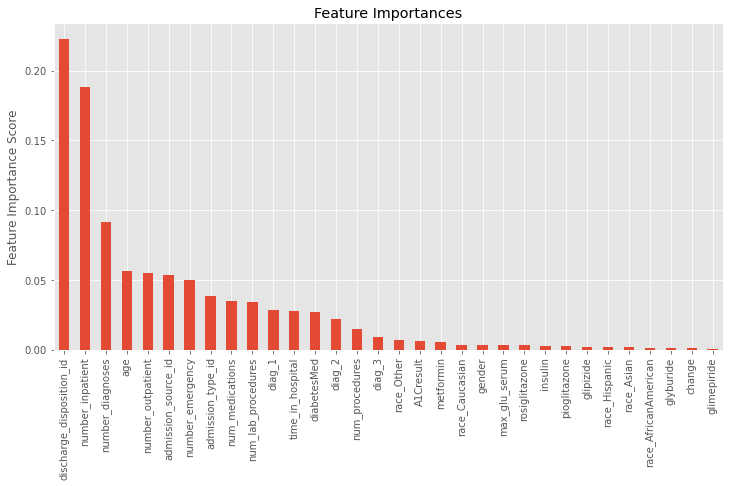

In [269]:
gbm0 = GradientBoostingClassifier() 
gbm0.fit(X_train,y_train)
gbm0_pred = gbm0.predict(X_val)

print('\nGradient Boost [0] Performance:')
print('-----------------------------------')
print('F1 Score micro        : ', metrics.f1_score(y_val, gbm0_pred,average='micro'))
print('F1 Score macro        : ', metrics.f1_score(y_val, gbm0_pred,average='macro'))
print('Confusion Matrix:\n ', confusion_matrix(y_val, gbm0_pred))

feat_imp = pd.Series(gbm0.feature_importances_, predictors).sort_values(ascending=False)
fig = plt.figure(figsize=(12, 6))
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

HyperParameter tuning roadmap: 

1. Decide a relatively higher value for learning rate and tune the number of estimators requried for that. 
2. Tune the tree specific parameters (min_samples_split, min_samples_leaf, max_depth, max_features) for that learning rate 
3. Tune subsample, and lower learning rate as much as possible computationally and increase the number of estimators accordingly.

##### Step 1 - Find the number of estimators for a high learning rate

In order to decide on boosting parameters, we need to set some initial values of other parameters. Lets take the following values:

1. min_samples_split = 400 : This should be ~0.5-1% of total values. Since this is imbalanced multi-class problem, we’ll take a small value from the range (our total sample points ~71k).
2. min_samples_leaf = 50 : Can be selected based on intuition. This is just used for preventing overfitting and again a small value because of imbalanced classes.
3. max_depth = 8 : Should be chosen (5-8) based on the number of observations and predictors. This has ~71K rows and 32 columns so lets take 8 here.
4. max_features = ‘sqrt’ : Its a general rule of thumb to start with square root.
5. subsample = 0.8 : This is a commonly used used start value

Please note that all the above are just initial estimates and will be tuned later. Lets take the default learning rate of 0.1 here and check the optimum number of trees for that. For this purpose, we can do a grid search and test out values from 20 to 80 in steps of 10.

In [250]:
#1.0 - Grid seach on n_estimators
param_test1 = {'n_estimators':range(20,81,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, 
                                                               min_samples_split=400, 
                                                               min_samples_leaf=50,
                                                               max_depth=8,
                                                               max_features='sqrt', 
                                                               subsample=0.8,
                                                               random_state=101), param_grid = param_test1, scoring='f1_micro',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train,y_train)

/home/trojan/miniconda3/envs/ds/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=8,
                                                  max_features='sqrt',
                                                  min_samples_leaf=50,
                                                  min_samples_split=400,
                                                  random_state=101,
                                                  subsample=0.8),
             iid=False, n_jobs=4,
             param_grid={'n_estimators': range(20, 81, 10)},
             scoring='f1_micro')

In [254]:
gsearch1.best_params_, gsearch1.best_score_

({'n_estimators': 70}, 0.6198314803619858)

So we got 70 as the optimal estimators for the 0.1 learning rate. Note that 70 is a reasonable value and can be used as it is. But it might not be the same in all cases. Other situations:

1. If the value is around 20, you might want to try lowering the learning rate to 0.05 and re-run grid search.
2. If the values are too high ~100, tuning the other parameters will take long time and you can try a higher learning rate.


##### Step 2 - Tune tree-specific parameters

Now, lets move onto tuning the tree parameters. We will do this in 3 stages:

   1. Tune max_depth and min_samples_split
   2. Tune min_samples_leaf
   3. Tune max_features


In [255]:
#2.1 - Grid seach on max_depth and min_samples_split
param_test2 = {'max_depth':range(3,16,3), 'min_samples_split':range(200,1001,200)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=70,
                                                max_features='sqrt', subsample=0.8, random_state=101), 
                       param_grid = param_test2, scoring='f1_micro',n_jobs=4,iid=False, cv=5)
gsearch2.fit(X_train,y_train)

/home/trojan/miniconda3/envs/ds/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_features='sqrt',
                                                  n_estimators=70,
                                                  random_state=101,
                                                  subsample=0.8),
             iid=False, n_jobs=4,
             param_grid={'max_depth': range(3, 16, 3),
                         'min_samples_split': range(200, 1001, 200)},
             scoring='f1_micro')

In [258]:
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 12, 'min_samples_split': 800}, 0.6206105275287552)

In [259]:
#2.2 - Grid seach on min_samples_leaf
param_test3 = {'min_samples_leaf':range(30,71,10)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=70,min_samples_split=800, 
                                                               max_depth=12, max_features='sqrt', subsample=0.8, random_state=101), 
                       param_grid = param_test3, scoring='f1_micro',n_jobs=4,iid=False, cv=5)
gsearch3.fit(X_train,y_train)

/home/trojan/miniconda3/envs/ds/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=12,
                                                  max_features='sqrt',
                                                  min_samples_split=800,
                                                  n_estimators=70,
                                                  random_state=101,
                                                  subsample=0.8),
             iid=False, n_jobs=4,
             param_grid={'min_samples_leaf': range(30, 71, 10)},
             scoring='f1_micro')

In [260]:
gsearch3.best_params_, gsearch3.best_score_

({'min_samples_leaf': 70}, 0.6203308750960945)

In [261]:
# 2.3 Grid seach on max_features
param_test4 = {'max_features':range(4,20,2)}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=70,max_depth=12, 
                            min_samples_split=800, min_samples_leaf=70, subsample=0.8, random_state=101),
                       param_grid = param_test4, scoring='f1_micro',n_jobs=4,iid=False, cv=5)
gsearch4.fit(X_train,y_train)

/home/trojan/miniconda3/envs/ds/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=12,
                                                  min_samples_leaf=70,
                                                  min_samples_split=800,
                                                  n_estimators=70,
                                                  random_state=101,
                                                  subsample=0.8),
             iid=False, n_jobs=4, param_grid={'max_features': range(4, 20, 2)},
             scoring='f1_micro')

In [262]:
gsearch4.best_params_, gsearch4.best_score_

({'max_features': 18}, 0.6204906194859189)

In [263]:
#The best parameter values so far: 
gsearch4.best_estimator_

GradientBoostingClassifier(max_depth=12, max_features=18, min_samples_leaf=70,
                           min_samples_split=800, n_estimators=70,
                           random_state=101, subsample=0.8)

Let's see the GBM performance on our validation set with hyperparameters choosen so far


Gradient Boost [1] Performance:
-----------------------------------
F1 Score micro        :  0.6152125279642058
F1 Score macro        :  0.36337173599046196
Confusion Matrix:
  [[5824  571    6]
 [2622  760    8]
 [ 717  204   16]]


Text(0, 0.5, 'Feature Importance Score')

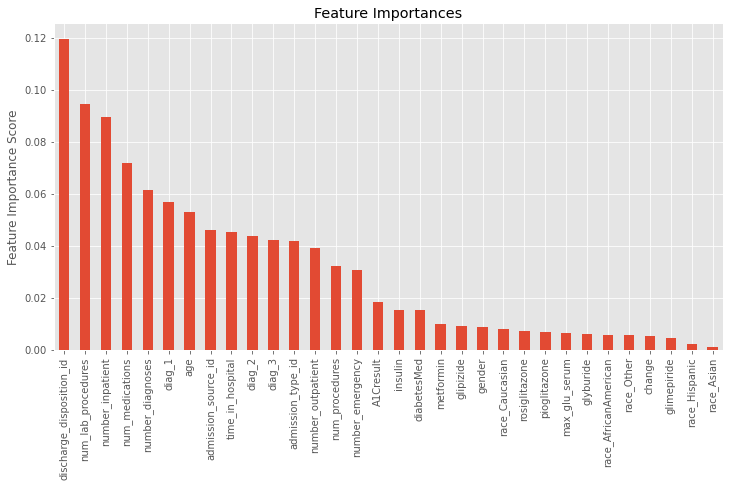

In [271]:
gbm1 = GradientBoostingClassifier(max_depth=12, max_features=18, min_samples_leaf=70,
                           min_samples_split=800, n_estimators=70,
                           random_state=101, subsample=0.8) 
gbm1.fit(X_train,y_train)
gbm1_pred = gbm1.predict(X_val)

print('\nGradient Boost [1] Performance:')
print('-----------------------------------')
print('F1 Score micro        : ', metrics.f1_score(y_val, gbm1_pred,average='micro'))
print('F1 Score macro        : ', metrics.f1_score(y_val, gbm1_pred,average='macro'))
print('Confusion Matrix:\n ', confusion_matrix(y_val, gbm1_pred))

feat_imp = pd.Series(gbm1.feature_importances_, predictors).sort_values(ascending=False)
fig = plt.figure(figsize=(12, 6))
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

We can see some improvement in F1 score (macro & micro), and a change in feature importance ranking. 

##### Step3 - Tune Subsample and Lower Learning Rate

In [265]:
#3.1 Grid seach on subsample
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9, 1]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=70,max_depth=12, 
                            min_samples_split=800, min_samples_leaf=70, random_state=101, max_features=18),
                       param_grid = param_test5, scoring='f1_micro',n_jobs=4,iid=False, cv=5)
gsearch5.fit(X_train,y_train)

/home/trojan/miniconda3/envs/ds/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=12, max_features=18,
                                                  min_samples_leaf=70,
                                                  min_samples_split=800,
                                                  n_estimators=70,
                                                  random_state=101),
             iid=False, n_jobs=4,
             param_grid={'subsample': [0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 1]},
             scoring='f1_micro')

In [266]:
gsearch5.best_params_, gsearch5.best_score_

({'subsample': 0.85}, 0.6208102239761104)

With all tuned lets get GBM performance on our validation set


Gradient Boost [2] Performance:
-----------------------------------
F1 Score micro        :  0.5878076062639821
F1 Score macro        :  0.3846271851942651
Confusion Matrix:
  [[5248 1072   81]
 [2325 1012   53]
 [ 621  270   46]]


Text(0, 0.5, 'Feature Importance Score')

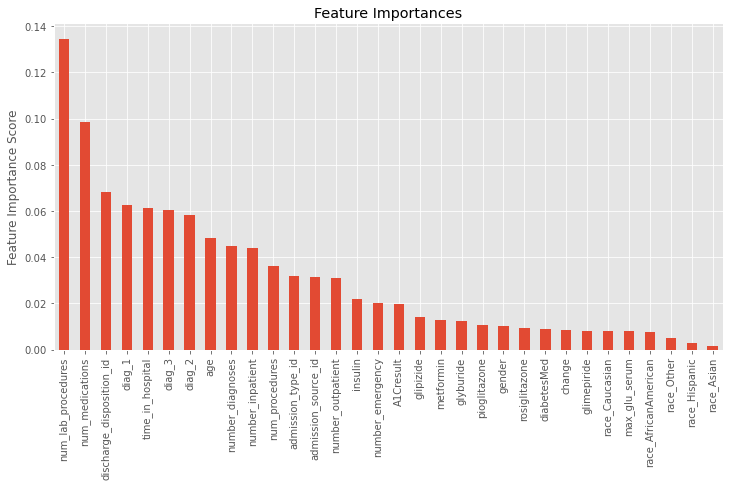

In [272]:
#3.2 reducing the learning rate and proportionally increasing the number of estimators 
gbm2 = GradientBoostingClassifier(max_depth=12, max_features=18, min_samples_leaf=70,
                           min_samples_split=800, n_estimators=700,
                           random_state=101, subsample=0.85, learning_rate=0.1) 
gbm2.fit(X_train,y_train)
gbm2_pred = gbm2.predict(X_val)

print('\nGradient Boost [2] Performance:')
print('-----------------------------------')
print('F1 Score micro        : ', metrics.f1_score(y_val, gbm2_pred,average='micro'))
print('F1 Score macro        : ', metrics.f1_score(y_val, gbm2_pred,average='macro'))
print('Confusion Matrix:\n ', confusion_matrix(y_val, gbm2_pred))

feat_imp = pd.Series(gbm2.feature_importances_, predictors).sort_values(ascending=False)
fig = plt.figure(figsize=(12, 6))
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

Even though confusion matrix and F1 score macro became better, yet our F1 score micro has dropped to 0.5878. 

Now lets try reducing the learning rate and proportionally increasing the number of estimators to get more robust results:


Gradient Boost [3] Performance:
-----------------------------------
F1 Score micro        :  0.6141871737509321
F1 Score macro        :  0.362448377830546
Confusion Matrix:
  [[5838  555    8]
 [2649  732    9]
 [ 713  205   19]]


Text(0, 0.5, 'Feature Importance Score')

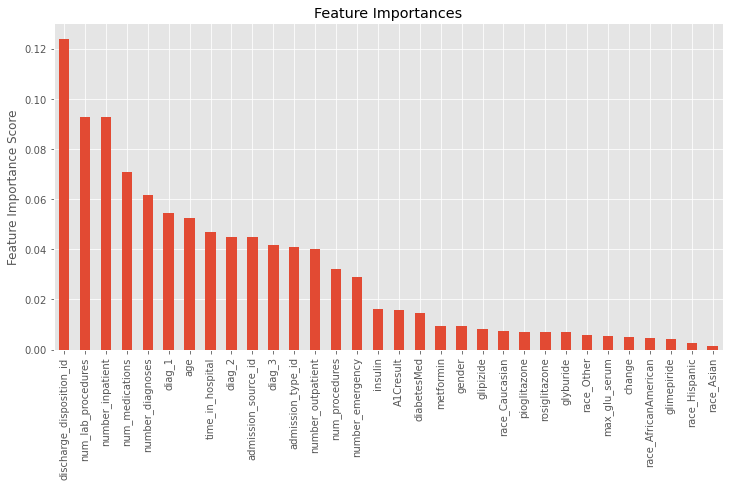

In [273]:
#3.3 reducing the learning rate to 50% and proportionally increasing the number of estimators 
gbm3 = GradientBoostingClassifier(max_depth=12, max_features=18, min_samples_leaf=70,
                           min_samples_split=800, n_estimators=140,
                           random_state=101, subsample=0.85, learning_rate=0.05) 
gbm3.fit(X_train,y_train)
gbm3_pred = gbm3.predict(X_val)

print('\nGradient Boost [3] Performance:')
print('-----------------------------------')
print('F1 Score micro        : ', metrics.f1_score(y_val, gbm3_pred,average='micro'))
print('F1 Score macro        : ', metrics.f1_score(y_val, gbm3_pred,average='macro'))
print('Confusion Matrix:\n ', confusion_matrix(y_val, gbm3_pred))

feat_imp = pd.Series(gbm3.feature_importances_, predictors).sort_values(ascending=False)
fig = plt.figure(figsize=(12, 6))
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')


Gradient Boost [4] Performance:
-----------------------------------
F1 Score micro        :  0.6147464578672632
F1 Score macro        :  0.363164182489389
Confusion Matrix:
  [[5832  564    5]
 [2639  745    6]
 [ 716  203   18]]


Text(0, 0.5, 'Feature Importance Score')

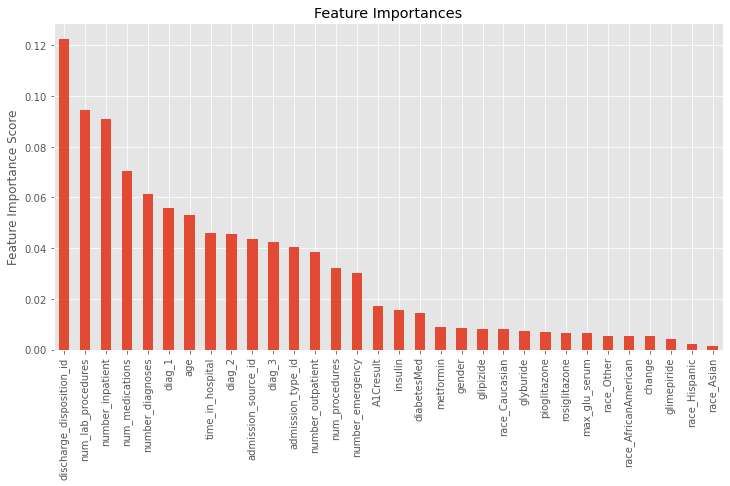

In [274]:
#3.4 reducing the learning rate to 10% and proportionally increasing the number of estimators 
gbm4 = GradientBoostingClassifier(max_depth=12, max_features=18, min_samples_leaf=70,
                           min_samples_split=800, n_estimators=700,
                           random_state=101, subsample=0.85, learning_rate=0.01) 
gbm4.fit(X_train,y_train)
gbm4_pred = gbm4.predict(X_val)

print('\nGradient Boost [4] Performance:')
print('-----------------------------------')
print('F1 Score micro        : ', metrics.f1_score(y_val, gbm4_pred,average='micro'))
print('F1 Score macro        : ', metrics.f1_score(y_val, gbm4_pred,average='macro'))
print('Confusion Matrix:\n ', confusion_matrix(y_val, gbm4_pred))

feat_imp = pd.Series(gbm4.feature_importances_, predictors).sort_values(ascending=False)
fig = plt.figure(figsize=(12, 6))
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')


Gradient Boost [5] Performance:
-----------------------------------
F1 Score micro        :  0.6150260999254288
F1 Score macro        :  0.363352980542246
Confusion Matrix:
  [[5841  555    5]
 [2646  738    6]
 [ 713  205   19]]


Text(0, 0.5, 'Feature Importance Score')

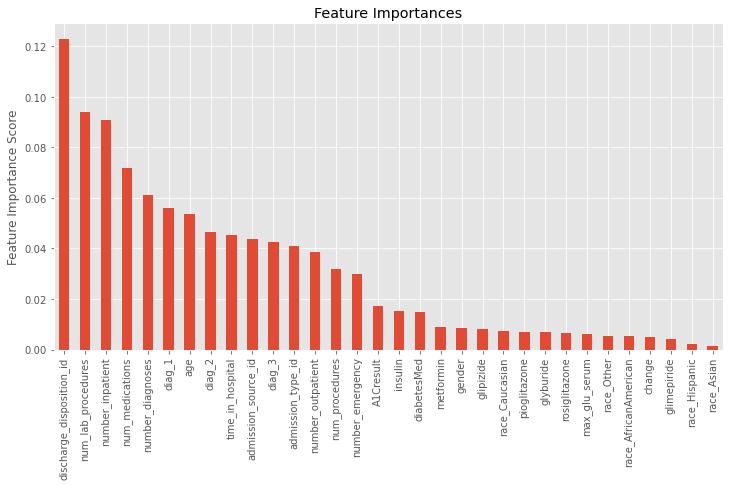

In [275]:
#3.5 reducing the learning rate to 5% and proportionally increasing the number of estimators 
gbm5 = GradientBoostingClassifier(max_depth=12, max_features=18, min_samples_leaf=70,
                           min_samples_split=800, n_estimators=1400,
                           random_state=101, subsample=0.85, learning_rate=0.005) 
gbm5.fit(X_train,y_train)
gbm5_pred = gbm5.predict(X_val)

print('\nGradient Boost [5] Performance:')
print('-----------------------------------')
print('F1 Score micro        : ', metrics.f1_score(y_val, gbm5_pred,average='micro'))
print('F1 Score macro        : ', metrics.f1_score(y_val, gbm5_pred,average='macro'))
print('Confusion Matrix:\n ', confusion_matrix(y_val, gbm5_pred))

feat_imp = pd.Series(gbm5.feature_importances_, predictors).sort_values(ascending=False)
fig = plt.figure(figsize=(12, 6))
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

With learning rate of 0.005 and number of estemators 1400, we have acheived the best balance between micro and macro F1 scores, and hence the best result. 

###### Micro vs Macro F1 Score
When all the labels are more or less equally sized (have roughly the same number of instances), we use any f1 score averaging method.

If we think there are labels with more instances than others and if we want to bias your metric towards the most populated ones, use micro f1 score.

If we think there are labels with more instances than others and if we want to bias your metric toward the least populated ones (or at least you don't want to bias toward the most populated ones), use macro f1 score.

If the microf1 score result is significantly lower than the macro one, it means that we have some gross misclassification in the most populated labels, whereas our smaller labels are probably correctly classified. If the macro f1 score result is significantly lower than the micromedia one, it means your smaller labels are poorly classified, whereas your larger ones are probably correctly classified, and that is what is happening in our dataset.



### Final Performance on Testing Data 


Gradient Boost Final Performance:
-----------------------------------
F1 Score micro        :  0.6214578672632364
F1 Score macro        :  0.3612444410496832
Confusion Matrix:
  [[5899  553    4]
 [2571  760    5]
 [ 716  212    8]]


Text(0, 0.5, 'Feature Importance Score')

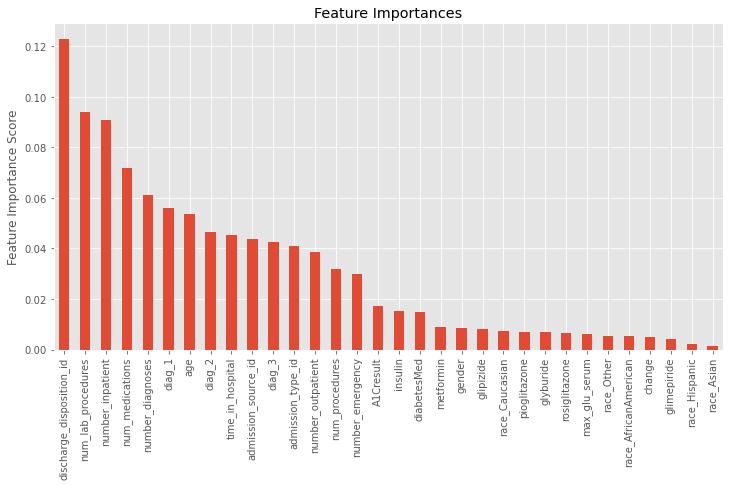

In [276]:
#Performance on test dataset
gbm5f_pred = gbm5.predict(X_test)

print('\nGradient Boost Final Performance:')
print('-----------------------------------')
print('F1 Score micro        : ', metrics.f1_score(y_test, gbm5f_pred,average='micro'))
print('F1 Score macro        : ', metrics.f1_score(y_test, gbm5f_pred,average='macro'))
print('Confusion Matrix:\n ', confusion_matrix(y_test, gbm5f_pred))

feat_imp = pd.Series(gbm5.feature_importances_, predictors).sort_values(ascending=False)
fig = plt.figure(figsize=(12, 6))
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

### Conclusion

In this project, we used Diabetes Patient dataset to build a Readmitted Prediction, where we have acheived the best prediction performance using Gradient Boost classifier.

   * F1 Score (micro): 0.6215
   * F1 Score (macro): 0.3612

The main reasons for not high performance is the fact that our labels are not palnced thoughout the dataset, where 1 label (No readmittion) accounts for over 60% of the data points, while another label (Readmitted in < 30 days) accounts for only ~8%. Another reason for low performance is that our target has very low correlation with all of our predectors. 

##### Future Work
In the future, we can try the following to improve the performance of our classifier: 
1. combine (readmitted in < 30 days) and (readmitted in > 30 days) into one feature, and turn the problem in to binary classification problem (readmitted vs not readmmited) which is going to result in a better palanced label classes. 
2. We can try selecting a subset of feature, with higher classification importance according to our classifier, and just using those in training. 

##### References
* https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008
* https://www.hindawi.com/journals/bmri/2014/781670/
* https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/